In [3]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf
from tqdm import tqdm

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Setup

In [4]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

# [I] Loading the data

In [5]:
scores_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\users_with_scores.parquet')
scores_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0,0,1,0
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0,0,1,0
2,2326,0,hellpop65.48993,Hellpop65,2005-11-14 11:00:00,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0,0,0,0
3,3098,0,latarnik.52897,Latarnik,2005-12-02 11:00:00,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0,0,0,1
4,1866,23,rochefortchris.697017,RochefortChris,2012-10-02 10:00:00,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0,0,1,0


In [6]:
ratings_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\ratings.parquet')
ratings_ddf.head()

,date,bid,uid,rating,has_review,review,compound
0,2015-08-20 10:00:00,142544,nmann08.184925,2.88,True,"From a bottle, pours a piss yellow color with ...",0
1,2015-11-14 11:00:00,120824,nmann08.184925,3.56,False,None,0
2,2011-11-18 11:00:00,47581,nmann08.184925,4.50,False,None,0
3,2013-05-03 10:00:00,93113,nmann08.184925,3.75,False,None,0
4,2015-01-24 11:00:00,875,nmann08.184925,3.81,False,None,0


In [7]:
beers_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\beers.parquet')
beers_ddf.head()

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,name,style,abv
0,5,1538,3.441203,520,0.338101,78.0,89.0,Amber,Vienna Lager,4.5
1,6,2660,3.657617,968,0.363910,82.0,90.0,Turbodog,English Brown Ale,5.6
2,7,2977,3.265694,778,0.261337,74.0,88.0,Purple Haze,Fruit / Vegetable Beer,4.2
3,8,132,3.290682,70,0.530303,77.0,89.0,Wheat,American Adjunct Lager,4.2
4,9,215,3.172698,120,0.558140,74.0,83.0,Golden,American Pale Lager,4.2


In [8]:
scores_ddf.compute().shape

(57108, 15)

In [9]:
cfm_scores = scores_ddf[scores_ddf["is_cfm"] == True]
ratings_cfm_ddf = ratings_ddf.merge(cfm_scores, on="uid", how="inner")
ratings_cfm_ddf['rating'].mean().compute()

,date,bid,uid,rating,has_review,review,compound,n_ratings,n_reviews,username,...,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,2014-01-25 11:00:00,19827,jaydoc.265507,3.25,False,None,0,9987,16,jaydoc,...,"United States, Kansas",United States,-0.443259,-0.331347,0.304296,0.062381,1,0,1,0
1,2014-01-25 11:00:00,20842,jaydoc.265507,3.75,False,None,0,9987,16,jaydoc,...,"United States, Kansas",United States,-0.443259,-0.331347,0.304296,0.062381,1,0,1,0
2,2013-11-27 11:00:00,4720,jaydoc.265507,3.50,False,None,0,9987,16,jaydoc,...,"United States, Kansas",United States,-0.443259,-0.331347,0.304296,0.062381,1,0,1,0
3,2013-11-27 11:00:00,41037,jaydoc.265507,4.00,False,None,0,9987,16,jaydoc,...,"United States, Kansas",United States,-0.443259,-0.331347,0.304296,0.062381,1,0,1,0
4,2013-11-27 11:00:00,41012,jaydoc.265507,4.00,False,None,0,9987,16,jaydoc,...,"United States, Kansas",United States,-0.443259,-0.331347,0.304296,0.062381,1,0,1,0


3.9247556815410296

In [12]:
exp_scores = scores_ddf[scores_ddf["is_exp"] == True]
ratings_exp_ddf = ratings_ddf.merge(exp_scores, on="uid", how="inner")
ratings_exp_ddf['rating'].mean().compute()

4.393289570287195

In [13]:
xpl_scores = scores_ddf[scores_ddf["is_xpl"] == True]
ratings_xpl_ddf = ratings_ddf.merge(xpl_scores, on="uid", how="inner")
ratings_xpl_ddf['rating'].mean().compute()

3.8067740577413063

In [14]:
adv_scores = scores_ddf[scores_ddf["is_adv"] == True]
ratings_adv_ddf = ratings_ddf.merge(adv_scores, on="uid", how="inner")
ratings_adv_ddf['rating'].mean().compute()

3.454024245033038

In [26]:
from processing import sentiment_pipeline_vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()

def ratings_categories_sentiment(score_ddf, category, frac=0.1, save=False):
    """
    Returns a dataframe with the sentiment scores for a given category
    """
    # only take ratings from conformist users
    ratings_category_ddf = ratings_ddf.merge(score_ddf, on="uid", how="inner")

    # only take beers with reviews
    ratings_category_ddf = ratings_category_ddf[ratings_category_ddf["has_review"] == True]
    
    # sample
    #ratings_category_ddf = ratings_category_ddf.sample(frac=1, random_state=42)
    ratings_category_ddf = ratings_category_ddf.sample(frac=frac, random_state=42)
    
    # compute sentiment scores
    analyser = SentimentIntensityAnalyzer()
    ratings_category_ddf['sentiment_scores'] = ratings_category_ddf['review'].apply(lambda review: analyser.polarity_scores(review), meta=('review', 'float'))
    ratings_category_ddf['compound_score'] = ratings_category_ddf['sentiment_scores'].apply(lambda score_dict: score_dict['compound'], meta=('sentiment_scores', 'float'))

    if save:
        ratings_category_ddf.to_parquet(
            ing.build_path(folderind="ba", filename=f"sentiment_analysis/{category}_sentiment", ext=".parquet", basepath=ing.REFINED_PATH))
    
    return ratings_category_ddf

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Henrique\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
cfm_sentiments_sample = ratings_categories_sentiment(scores_ddf[scores_ddf["is_cfm"] == True], "conformist", save=True)
exp_sentiments_sample = ratings_categories_sentiment(scores_ddf[scores_ddf["is_exp"] == True], "expert_like", save=True)
xpl_sentiments_sample = ratings_categories_sentiment(scores_ddf[scores_ddf["is_xpl"] == True], "explorator", save=True)
adv_sentiments_sample = ratings_categories_sentiment(scores_ddf[scores_ddf["is_adv"] == True], "adventurer", save=True)

In [27]:
overall_sentiments_sample = ratings_categories_sentiment(scores_ddf, "general", save=True)

In [ ]:
# read parquet files if already computed
cfm_sentiments_sample = ing.read_parquet('RefinedData\BeerAdvocate\\sentiment_analysis\\conformist_sentiment.parquet')
exp_sentiments_sample = ing.read_parquet('RefinedData\BeerAdvocate\\sentiment_analysis\\expert_like_sentiment.parquet')
xpl_sentiments_sample = ing.read_parquet('RefinedData\BeerAdvocate\\sentiment_analysis\\explorator_sentiment.parquet')
adv_sentiments_sample = ing.read_parquet('RefinedData\BeerAdvocate\\sentiment_analysis\\adventurer_sentiment.parquet')

# [II] Sentiment analysis of each category of users

## Conformist sentiment analysis

### nlp pipeline test

In [44]:
import spacy
import asent

# load spacy pipeline
nlp = spacy.blank('en')
nlp.add_pipe('sentencizer')

# add the rule-based sentiment model
nlp.add_pipe('asent_en_v1')

# try an example
text = 'On draft, pours a dark brown with red hues, wispy white head that just sits on top of the beer.The nose is faint coffee, it really isn\'t that present.  Some citrus hops, cocoa, caramel, with just faint roast of espresso.  The flavor is more coffee, but still not that much, orange peel, some resin.  This is a bit weird since I don\'t get alot of coffee.  It\'s fine, but I would have liked it more if the coffee was more present and pronounced.'
doc = nlp(text)

# print polarity of document, scaled to be between -1, and 1
print(doc._.polarity)
# neg=0.0 neu=0.631 pos=0.369 compound=0.7526

# Naturally, a simple score can be quite unsatisfying, thus Asent implements a series of visualizer to interpret the results:
asent.visualize(doc, style='prediction')
 # or
asent.visualize(doc, style='analysis')

neg=0.018 neu=0.445 pos=0.037 compound=0.0571


In [59]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sid.polarity_scores(text)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Henrique\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.184, 'neu': 0.704, 'pos': 0.112, 'compound': -0.5625}

In [61]:
type(sid.polarity_scores(text)["compound"])

float

In [47]:
"""
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("LiYuan/amazon-review-sentiment-analysis")

model = AutoModelForSequenceClassification.from_pretrained("LiYuan/amazon-review-sentiment-analysis")

# do inference using the model
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# try an example
text = 'On draft, pours a dark brown with red hues, wispy white head that just sits on top of the beer.The nose is faint coffee, it really isn\'t that present.  Some citrus hops, cocoa, caramel, with just faint roast of espresso.  The flavor is more coffee, but still not that much, orange peel, some resin.  This is a bit weird since I don\'t get alot of coffee.  It\'s fine, but I would have liked it more if the coffee was more present and pronounced.'
nlp(text)
"""




[{'label': '3 stars', 'score': 0.5791990160942078}]

In [52]:
from processing import sentiment_pipeline_vader
# conformist ratings
cfm_users_ddf = scores_ddf[scores_ddf["is_cfm"] == True]

# only take ratings from conformist users
cf_ratings_conformist_ddf = ratings_ddf.merge(cfm_users_ddf, on="uid", how="inner")

# only take beers with reviews
cf_ratings_conformist_ddf = cf_ratings_conformist_ddf[cf_ratings_conformist_ddf["has_review"] == True]

cf_ratings_conformist_ddf.head()



,date,bid,uid,rating,has_review,review,compound,n_ratings,n_reviews,username,...,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
124,2012-07-14 10:00:00,19827,othershoe2.233642,3.68,True,Pours a rich brownish red with some chill haze...,0,1315,1315,OtherShoe2,...,"United States, Massachusetts",United States,2.732579,1.192624,0.06692,0.08289,1,0,0,0
125,2012-04-07 10:00:00,4720,othershoe2.233642,3.58,True,Pours clear medium gold with a slight bubbly w...,0,1315,1315,OtherShoe2,...,"United States, Massachusetts",United States,2.732579,1.192624,0.06692,0.08289,1,0,0,0
126,2011-03-05 11:00:00,875,othershoe2.233642,4.64,True,"Pours deep brown with a good foamy tan head, t...",0,1315,1315,OtherShoe2,...,"United States, Massachusetts",United States,2.732579,1.192624,0.06692,0.08289,1,0,0,0
127,2010-10-29 10:00:00,39258,othershoe2.233642,3.70,True,Pours a deep amber with a cream colored head t...,0,1315,1315,OtherShoe2,...,"United States, Massachusetts",United States,2.732579,1.192624,0.06692,0.08289,1,0,0,0
128,2012-07-08 10:00:00,3275,othershoe2.233642,3.58,True,Pours medium gold with a robust white head. Ni...,0,1315,1315,OtherShoe2,...,"United States, Massachusetts",United States,2.732579,1.192624,0.06692,0.08289,1,0,0,0


In [53]:
cf_ratings_conformist_ddf.compute().shape

(342252, 21)

In [54]:
cf_ratings_samples = cf_ratings_conformist_ddf.sample(frac=0.1, random_state=42)

In [55]:
cf_ratings_samples.compute().shape

(34228, 21)

In [63]:
analyser = SentimentIntensityAnalyzer()
cf_ratings_samples['sentiment_scores'] = cf_ratings_samples['review'].apply(lambda review: analyser.polarity_scores(review), meta=('review', 'float'))

In [65]:
cf_ratings_samples.head()

,date,bid,uid,rating,has_review,review,compound,n_ratings,n_reviews,username,...,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv,sentiment_scores
10966,2016-01-16 11:00:00,42286,dragginballs76.1066881,2.65,True,Pour very cloudy deep orange very thin white h...,0,947,689,Dragginballs76,...,United States,3.274919,1.140663e+00,0.157339,0.016895,1,0,0,0,"{'neg': 0.106, 'neu': 0.766, 'pos': 0.128, 'co..."
11548,2005-12-29 11:00:00,25858,billolick.4099,3.92,True,The sign outside Brooklyn's Waterfront Ale hou...,0,3922,3696,Billolick,...,United States,2.317618,1.718985e+00,0.240439,0.04921,1,1,1,0,"{'neg': 0.137, 'neu': 0.832, 'pos': 0.031, 'co..."
14265,2003-02-20 11:00:00,221,johnrobe.309,4.09,True,This is cast and mold for a traditional style ...,0,145,145,johnrobe,...,United States,2.479728,1.439393e+00,0.172414,0.131034,1,0,0,0,"{'neg': 0.029, 'neu': 0.85, 'pos': 0.121, 'com..."
5943,2003-06-22 10:00:00,36,kmo1030.2122,4.33,True,this house ale is a beautiful rich ruby brown ...,0,642,642,kmo1030,...,United States,3.527465,1.717163e+00,0.077882,0.062305,1,1,0,0,"{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp..."
11653,2012-01-23 11:00:00,77595,blurryvisi0n.572344,3.67,True,Poured unto a snifter. Appearance: I was told ...,0,1079,1079,BlurryVisi0n,...,United States,2.927731,1.330136e-10,0.074143,0.053753,1,0,0,0,"{'neg': 0.08, 'neu': 0.778, 'pos': 0.141, 'com..."


In [66]:
cf_ratings_samples['compound_score'] = cf_ratings_samples['sentiment_scores'].apply(lambda score_dict: score_dict['compound'], meta=('sentiment_scores', 'float'))

In [ ]:
# save to 
cf_ratings_samples.to_parquet(
    ing.build_path(folderind="ba/sentiment_analysis", filename="conformist_sentiment", ext=".parquet", basepath=ing.REFINED_PATH))

In [4]:
# load from parquet
cfm_sentiments_sample = ing.read_parquet('RefinedData\BeerAdvocate\sentiment_analysis.parquet')

In [7]:
cfm_sentiments_sample.head()

,date,bid,uid,rating,has_review,review,compound,n_ratings,n_reviews,username,...,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv,sentiment_scores,compound_score
10966,2016-01-16 11:00:00,42286,dragginballs76.1066881,2.65,True,Pour very cloudy deep orange very thin white h...,0,947,689,Dragginballs76,...,3.274919,1.140663e+00,0.157339,0.016895,1,0,0,0,"{'compound': 0.3417, 'neg': 0.106, 'neu': 0.76...",0.3417
11548,2005-12-29 11:00:00,25858,billolick.4099,3.92,True,The sign outside Brooklyn's Waterfront Ale hou...,0,3922,3696,Billolick,...,2.317618,1.718985e+00,0.240439,0.04921,1,1,1,0,"{'compound': -0.8098, 'neg': 0.137, 'neu': 0.8...",-0.8098
14265,2003-02-20 11:00:00,221,johnrobe.309,4.09,True,This is cast and mold for a traditional style ...,0,145,145,johnrobe,...,2.479728,1.439393e+00,0.172414,0.131034,1,0,0,0,"{'compound': 0.9273, 'neg': 0.029, 'neu': 0.85...",0.9273
5943,2003-06-22 10:00:00,36,kmo1030.2122,4.33,True,this house ale is a beautiful rich ruby brown ...,0,642,642,kmo1030,...,3.527465,1.717163e+00,0.077882,0.062305,1,1,0,0,"{'compound': 0.9698, 'neg': 0.0, 'neu': 0.755,...",0.9698
11653,2012-01-23 11:00:00,77595,blurryvisi0n.572344,3.67,True,Poured unto a snifter. Appearance: I was told ...,0,1079,1079,BlurryVisi0n,...,2.927731,1.330136e-10,0.074143,0.053753,1,0,0,0,"{'compound': 0.8133, 'neg': 0.08, 'neu': 0.778...",0.8133


In [11]:
compound_score = cfm_sentiments_sample['compound_score'].compute()
nb_pos = compound_score[compound_score > 0.05].shape[0]
nb_neg = compound_score[compound_score < -0.05].shape[0]
nb_neu = compound_score[compound_score.between(-0.05, 0.05)].shape[0]
nb_pos, nb_neg, nb_neu

(31790, 2020, 418)

<AxesSubplot:xlabel='compound_score', ylabel='Count'>

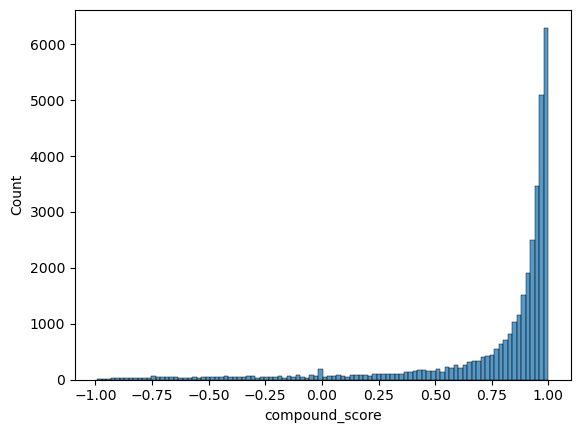

In [13]:
# plot histogram of sentiment scores
sns.histplot(compound_score, bins=100)

## expert-like sentiment analysis

In [9]:
compound_score = exp_sentiments_sample['compound_score'].compute()
nb_pos = compound_score[compound_score > 0.05].shape[0]
nb_neg = compound_score[compound_score < -0.05].shape[0]
nb_neu = compound_score[compound_score.between(-0.05, 0.05)].shape[0]
nb_pos, nb_neg, nb_neu

(3080, 115, 31)

In [11]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = compound_score.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")



Positive: 95.47%
Negative: 3.56%
Neutral: 0.96%


<AxesSubplot:xlabel='compound_score', ylabel='Count'>

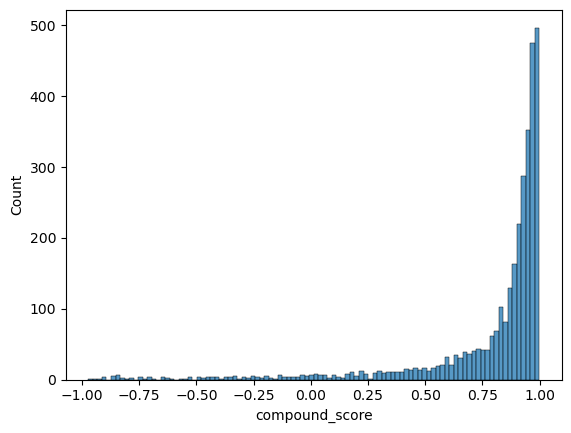

In [12]:
# plot histogram of sentiment scores
sns.histplot(compound_score, bins=100)

# explorer sentiment analysis

In [13]:
compound_score = xpl_sentiments_sample['compound_score'].compute()
nb_pos = compound_score[compound_score > 0.05].shape[0]
nb_neg = compound_score[compound_score < -0.05].shape[0]
nb_neu = compound_score[compound_score.between(-0.05, 0.05)].shape[0]
nb_pos, nb_neg, nb_neu

(722176, 63111, 11696)

In [14]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = compound_score.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 90.61%
Negative: 7.92%
Neutral: 1.47%


<AxesSubplot:xlabel='compound_score', ylabel='Count'>

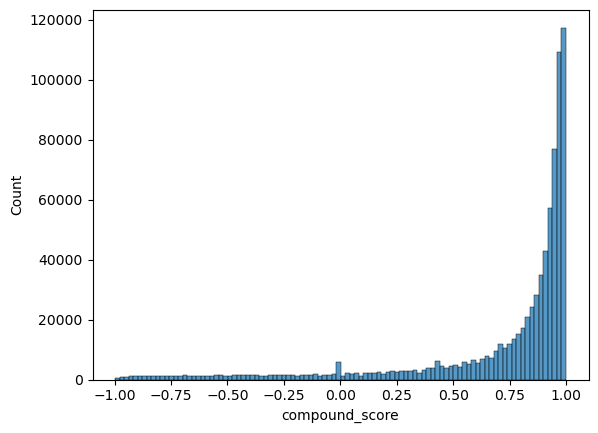

In [15]:
# plot histogram of sentiment scores
sns.histplot(compound_score, bins=100)

# adventurer sentiment analysis

In [16]:
compound_score = adv_sentiments_sample['compound_score'].compute()
nb_pos = compound_score[compound_score > 0.05].shape[0]
nb_neg = compound_score[compound_score < -0.05].shape[0]
nb_neu = compound_score[compound_score.between(-0.05, 0.05)].shape[0]

In [17]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = compound_score.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 87.56%
Negative: 10.72%
Neutral: 1.72%


<AxesSubplot:xlabel='compound_score', ylabel='Count'>

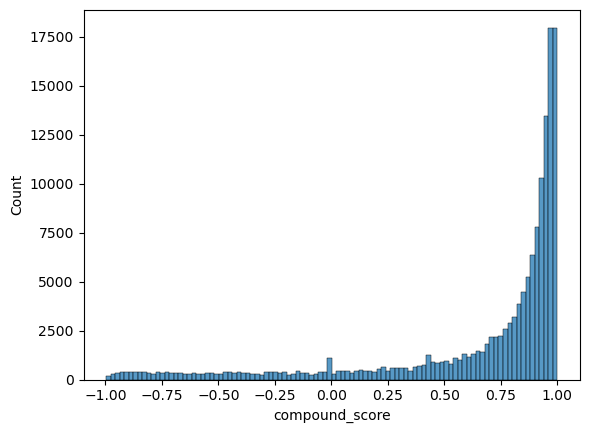

In [18]:
# plot histogram of sentiment scores
sns.histplot(compound_score, bins=100)

# conformist sentiment analysis

In [19]:
compound_score = cfm_sentiments_sample['compound_score'].compute()
nb_pos = compound_score[compound_score > 0.05].shape[0]
nb_neg = compound_score[compound_score < -0.05].shape[0]
nb_neu = compound_score[compound_score.between(-0.05, 0.05)].shape[0]

In [20]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = compound_score.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 93.05%
Negative: 5.71%
Neutral: 1.24%


<AxesSubplot:xlabel='compound_score', ylabel='Count'>

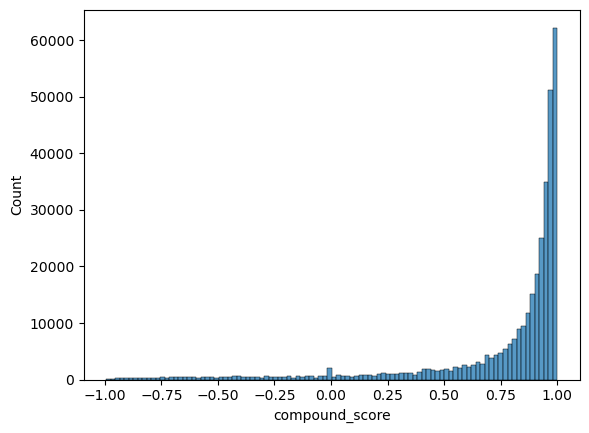

In [21]:
# plot histogram of sentiment scores
sns.histplot(compound_score, bins=100)

# sentiment analysis on sample of whole data(regardless of categories)

In [28]:
compound_score = overall_sentiments_sample['compound_score'].compute()
nb_pos = compound_score[compound_score > 0.05].shape[0]
nb_neg = compound_score[compound_score < -0.05].shape[0]
nb_neu = compound_score[compound_score.between(-0.05, 0.05)].shape[0]

In [29]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = compound_score.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 91.62%
Negative: 7.13%
Neutral: 1.24%


<AxesSubplot:xlabel='compound_score', ylabel='Count'>

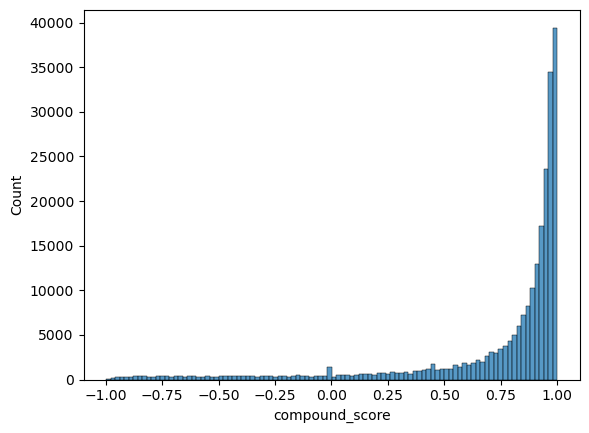

In [30]:
# plot histogram of sentiment scores
sns.histplot(compound_score, bins=100)

# Run same with BERT base since no much neutral

# Run with spacy pipeline

In [ ]:
def ratings_categories_sentiment_spacy(score_ddf, category, frac=0.1, save=False):
    """
    Returns a dataframe with the sentiment scores for a given category
    """
    # only take ratings from conformist users
    ratings_category_ddf = ratings_ddf.merge(score_ddf, on="uid", how="inner")

    # only take beers with reviews
    ratings_category_ddf = ratings_category_ddf[ratings_category_ddf["has_review"] == True]
    
    # sample
    #ratings_category_ddf = ratings_category_ddf.sample(frac=1, random_state=42)
    ratings_category_ddf = ratings_category_ddf.sample(frac=frac, random_state=42)
    
    # compute sentiment scores
    analyser = SentimentIntensityAnalyzer()

    nlp = spacy.load('en_core_web_sm')
    doc = nlp(ratings_category_ddf['review'])
    [total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
    ratings_category_ddf['sentiment_scores'] = ratings_category_ddf['review'].apply(lambda review: analyser.polarity_scores(review), meta=('review', 'float'))
    ratings_category_ddf['compound_score'] = ratings_category_ddf['sentiment_scores'].apply(lambda score_dict: score_dict['compound'], meta=('sentiment_scores', 'float'))

    if save:
        ratings_category_ddf.to_parquet(
            ing.build_path(folderind="ba", filename=f"sentiment_analysis/{category}_sentiment", ext=".parquet", basepath=ing.REFINED_PATH))
    
    return ratings_category_ddf

In [35]:
ratings_ddf_sample = ratings_ddf.sample(10000)

In [36]:
ratings_ddf_sample["review"] = ratings_ddf_sample["review"].astype('str')

In [37]:
text = ratings_ddf_sample[ratings_ddf_sample["has_review"] == True]["review"].values

In [39]:
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 3119703
text = ''.join(list(text))
doc = nlp(text)

In [42]:
from processing import sentiment_pipeline_vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

total_sent = []
[total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [43]:
total_sent = [sent for sent in total_sent if sent != None]

In [44]:
total_sent[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.5719, 0.7184, 0.7808, 0.0, 0.296]

Text(0, 0.5, 'Number of sentences')

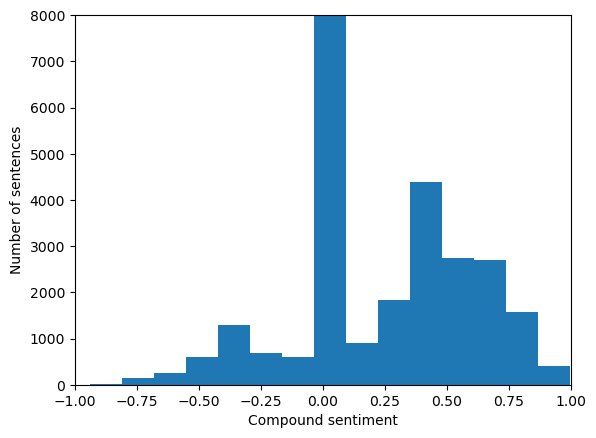

In [45]:
plt.hist(total_sent,bins = 15)
plt.xlim([-1,1])
plt.ylim([0,8000])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences')

In [50]:
# reprendre ce que j'ai fais dans nlp.py
reviews_df = ratings_ddf_sample[ratings_ddf_sample["has_review"] == True]["review"].astype("str")
reviews_df.head()

245257    From the 750ml capped bottle. Poured into a sn...
172034    The Czar, bottled 2008Served in a New Belgium ...
120194    Had this one last week in Montreal...poured in...
43692     Poured from a 750ml bottle corked and caged. R...
13231     A: Clear yellow pour with hints of orange thro...
Name: review, dtype: object

In [55]:
from nlp import VaderSentimentAnalyser
vader_analyser = VaderSentimentAnalyser()
sents = reviews_df.map(lambda text: vader_analyser.compute(text))

Text(0, 0.5, 'Number of reviews')

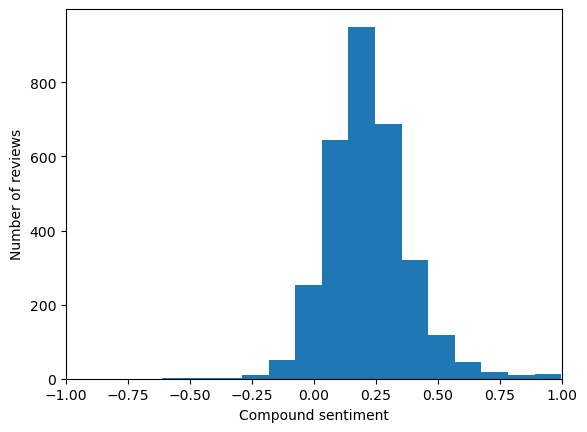

In [58]:
plt.hist(sents,bins = 15)
plt.xlim([-1,1])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of reviews')

In [64]:
sents = np.array(sents)
pos_ratio = len(sents[sents >= 0.05]) / len(sents)
neg_ratio = len(sents[sents <= -0.05]) / len(sents)
pos_ratio, neg_ratio

(0.8668373879641486, 0.029449423815621)